In [1]:
%pylab inline
import galsim
import numpy as np
import astropy.io.fits as pyfits

import imgutil
import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim

/home/xiangchong/work/gw_ipmu/work/FPFS2/sim


+ correlation of shape modes

In [3]:
# Get the  galaxy generator      
# Load data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   '../../galsim_train/COSMOS_25.2_training_sample/'
cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)

In [4]:
# PSF preparation
psfPre='psfPre'
# Basic parameters
ngrid       =   64
nrot        =   1
nx          =   1
ny          =   100000
ndata       =   nx*ny
scale       =   0.168
ngridTot    =   ngrid*nx
flux_scaling=   2.587

bigfft      =   galsim.GSParams(maximum_fft_size=10240)
# index
ifield=1
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
index       =   ifield%81400
record      =   param_cat[index]
# prepare the galaxies
gal0        =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
gal0        *=  flux_scaling

# Get the psf and nosie information 
psfFname    =   os.path.join(psfPre,'psf%04d.fits'%(ifield))
psfImg      =   galsim.fits.read(psfFname)
psfData=np.pad(psfImg.array,(11,10))
print(psfData.shape)

noiseHead   =   pyfits.getheader(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.) 
# Get the shear information
g1          =   noiseHead['g1']
g2          =   noiseHead['g2']
fwhm        =   noiseHead['fwhm'] 
#variance   =   noiseHead['var']
variance    =   noiseHead['var']/100.
rescale     =   noiseHead['rescale']
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)
final       =   galsim.Convolve([psfInt,gal0],gsparams=bigfft)

(64, 64)


In [5]:
# Noise
corPre='corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
corNoise    =   galsim.getCOSMOSNoise(file_name=corFname,rng=ud,cosmos_scale=scale,variance=variance)

corIn=pyfits.getdata(corFname)*variance
corIn=np.pad(corIn,(23,22))
corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones((ngrid,ngrid))))**2.)).real
corIn=corIn*corNum
powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
powModel=np.zeros((1,ngrid,ngrid))
powModel[0]=powIn

(100000, 64, 64)


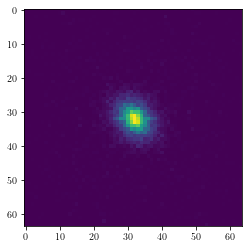

In [6]:
# original galaxy image
gal_image0   =   galsim.ImageF(ngrid,ngrid,scale=scale)
gal_image0.setOrigin(0,0)
final.drawImage(gal_image0,method='no_pixel')

# noisy galaxy image
gal_image   =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image.setOrigin(0,0)
for i in range(ny):
    # Prepare the subimage
    ix      =   0
    iy      =   i
    b       =   galsim.BoundsI(ix*ngrid, (ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_gal_image = gal_image[b]
    # Draw the galaxy image
    final.drawImage(sub_gal_image,method='no_pixel')

corNoise.applyTo(gal_image)
# image arrays
image_list=np.stack(np.vsplit(gal_image.array,ny))
print(image_list.shape)
galPow=imgutil.getFouPow(image_list[0])
subPow=imgutil.fitNoiPow(ngrid,galPow,np.ones((1,ngrid,ngrid)),26)
imshow(galPow-subPow)

In [7]:
fpTask=fpfsBase.fpfsTask(psfData)
a0=fpTask.measure(gal_image0.array)

## First Test: precise variance estiamtion
input noiFit which means the noise power function is known

In [8]:
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0])
a=fpTask.measure(image_list)

testing


In [9]:
print(np.var(a['fpfs_M00']),np.var(a['fpfs_M22c']),np.var(a['fpfs_M22s']),np.var(a['fpfs_M40']))
print(np.average(a['fpfs_N00N00']),np.average(a['fpfs_N22cN22c']),np.average(a['fpfs_N22sN22s']),np.average(a['fpfs_N40N40']))

46.41449800200595 47.80960258476143 47.77823476490142 166.80524987718775
46.58830304427995 47.81557994546739 48.01344353588302 167.47580141242676


In [10]:
print('N00N22c:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M22c']-a0['fpfs_M22c'])
print(np.average(ff))
print(np.average(a['fpfs_N00N22c']))
print('N00N22s:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M22s']-a0['fpfs_M22s'])
print(np.average(ff))
print(np.average(a['fpfs_N00N22s']))
print('N00N40:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M40']-a0['fpfs_M40'])
print(np.average(ff))
print(np.average(a['fpfs_N00N40']))

N00N22c:
-1.0904811540025907
-0.8503915378101836
N00N22s:
5.396743933564852
5.5372505435105435
N00N40:
-4.0720984160193145
-3.7131322380585625


## Second Test: noisy variance estiamtion
input noiModel which means the noise power function is not known, we use template to fit the noise power

In [11]:
fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
a=fpTask.measure(image_list)

In [12]:
print(np.var(a['fpfs_M00']),np.var(a['fpfs_M22c']),np.var(a['fpfs_M22s']),np.var(a['fpfs_M40']))
print(np.average(a['fpfs_N00N00']),np.average(a['fpfs_N22cN22c']),np.average(a['fpfs_N22sN22s']),np.average(a['fpfs_N40N40']))

46.4758118150164 47.80945438102356 47.778038406215174 170.66656337077987
46.76354740040787 47.99237154032659 48.19113717617458 168.04963715026952


In [13]:
print('N00N22c:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M22c']-a0['fpfs_M22c'])
print(np.average(ff))
print(np.average(a['fpfs_N00N22c']))
print('N00N22s:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M22s']-a0['fpfs_M22s'])
print(np.average(ff))
print(np.average(a['fpfs_N00N22s']))
print('N00N40:')
ff=(a['fpfs_M00']-a0['fpfs_M00'])*(a['fpfs_M40']-a0['fpfs_M40'])
print(np.average(ff))
print(np.average(a['fpfs_N00N40']))

N00N22c:
-1.0898017191882838
-0.8536211879186771
N00N22s:
5.393757988911009
5.558350553828465
N00N40:
-3.573336045512658
-3.7291476557675085
